# Why Resnet
The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the lower layers) to very complex features (at the deeper layers). However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent unbearably slow. More specifically, during gradient descent, as we backprop from the final layer back to the first layer, we are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). The following graphs show the training and test error as the number of iterations increases. With the increase in layers the error also increases. It is common to assume that overfitting is the reason for this problem but that is not the case.


# Iteration Vs Loss
<img src="IterVsloss.png">


ResNet uses residual blocks with  skip connections.  By stacking these ResNet blocks on top of each other, you can form a very deep network.
Having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that many such blocks can be stack on additional ResNet blocks with little risk of harming training set performance.



In [4]:
import numpy as np
import os
import time
from resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten

from imagenet_utils import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


2.0.8


NumPy:It provides an N-dimensional array type, the ndarray, which describes a collection of “items” of the same type. The items can be indexed using for example N integers. All the pixel values of the images are converted into an N-dimensional array.

Tensorflow:TensorFlow allows developers to create dataflow graphs—structures that describe how data moves through a graph, or a series of processing nodes. Each node in the graph represents a mathematical operation, and each connection or edge between nodes is a multidimensional data array, or tensor.

Keras:Keras proper does not do its own low-level operations, such as tensor products and convolutions; it relies on a back-end engine for that.In this  we are using tensorflow as its backend.

Scikitlearn: The library is focused on modeling data.It also provides a range of supervised and unsupervised learning algorithms via a consistent interface in Python.


In [6]:
PATH = os.getcwd()
# Define data path
data_path = PATH + '/images'
data_dir_list = os.listdir(data_path)

In [8]:
img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/'+ dataset + '/'+ img 
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        img_data_list.append(x)


Loaded the images of dataset-apple_pie

Loaded the images of dataset-baby_back_ribs

Loaded the images of dataset-baklava

Loaded the images of dataset-beef_carpaccio

Loaded the images of dataset-beef_tartare

Loaded the images of dataset-beet_salad

Loaded the images of dataset-beignets

Loaded the images of dataset-bibimbap

Loaded the images of dataset-bread_pudding

Loaded the images of dataset-breakfast_burrito



The images are loaded into a list img_data_list by looping through all the images in the training set.All images are to be of the standard shape of 224 x 224 with three channels for RGB.The images are converted into an array of shape (224 x 224 x 3).
The preprocess_input function is meant to adequate your image to the format the model requires.It subtracts the mean RGB channels of the dataset.

In [5]:
img_data = np.array(img_data_list)
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

(10000, 1, 224, 224, 3)
(1, 10000, 224, 224, 3)
(10000, 224, 224, 3)


The images are converted into an array and the size iof the array is checked. The array required for training is of the shape(n,224,224,3) where n=number of images in the dataset.Therefore the array is rolled horizontally across the columns to get the desired shape of (10000,224,224,3).

In [7]:
num_classes = 10
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:1000]=0
labels[1000:2000]=1
labels[2000:3000]=2
labels[3000:4000]=3
labels[4000:5000]=4
labels[5000:6000]=5
labels[6000:7000]=6
labels[7000:8000]=7
labels[8000:9000]=8
labels[9000:10000]=9

names = ['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

The class labels are defined and converted into encodings using the to_categorical function in NumPy.

In [8]:
x,y = shuffle(img_data,Y, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

The images and labels are shuffled and assigned into dependent and independent variables x and y.this step is important to make sure that the neural network doesnt look at the same images repeatedly.
# Training Set and Test Set
A neural network learns by example.The image along with its label is giving to the network and it makes mappings of the features that separate one image from another.Training the network to map these features is done with several images using a part of the dataset called training set.When the accuracy of the network is to be checked it cannot be done on the set of images it was trained on.Therefore a new set of images called a test set is created to make sure that the network sees completely new images it has never seen before.The accuracy must always be tested on the test set.In this case 20% of the entire data is set aside for testing.

# How the Neural Network works

The image classification is done by a convolutional neural network. In a CNN the image is broken into tiles. The first step is to preprocess the images by randomly cropping or flipping the images thereby adding noise to the image.Since the Food-101 dataset already consists of noisy images this step is omitted.


<img src="CNN.png">


The pixel values from the images are split into several feature maps.Only the dominant features i.e the highest value in a feature map is identified and a smaller feature map is created. This is done in order to reduce computation.This process of reducing the dimensions of an image by taking the maximum pixel value of a grid is called max-pooling.This also helps reduce overfitting and makes the model more generic.Again several such max-pooled feature maps are created which contain information of only dominant features.Later these f.maps are flattened and fed into the neural network.

In [9]:
model = ResNet50(weights='imagenet',include_top=False)
model.summary()
last_layer = model.output

Instructions for updating:
Colocations handled automatically by placer.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, None, None, 3) 0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256         conv1[0][0]                      
___________________

bn5c_branch2a (BatchNormalizatio (None, None, None, 51 2048        res5c_branch2a[0][0]             
____________________________________________________________________________________________________
activation_47 (Activation)       (None, None, None, 51 0           bn5c_branch2a[0][0]              
____________________________________________________________________________________________________
res5c_branch2b (Conv2D)          (None, None, None, 51 2359808     activation_47[0][0]              
____________________________________________________________________________________________________
bn5c_branch2b (BatchNormalizatio (None, None, None, 51 2048        res5c_branch2b[0][0]             
____________________________________________________________________________________________________
activation_48 (Activation)       (None, None, None, 51 0           bn5c_branch2b[0][0]              
___________________________________________________________________________________________

In [24]:
custom_resnet_model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D) (None, None, None, 3) 0           input_4[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472        zero_padding2d_3[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256         conv1[0][0]                      
___________________________________________________________________________________________

# Fine Tuning the ResNet model
Instead of training a neural network from scratch(which needs a lot of computation) it can be retrained to classify into labels we want. This can be done by 'freezing' earlier layers and adding layers at the end. It can be seen that the total number of trainable parameters has reduced after freezing the layers. By freezing a layer we dont retrain the weights of that layer. We stack new layers and train them.
for layer in custom_resnet_model2.layers[:-6],from this line we freeze the network except for the last 6 layers.Two Dense and Dropout layers are added.Dropout is randomly deleting certain neurons in the layer so that they dont develop codependency and lead to overfitting.

The final network along with frozen and newly added layers is trained for 20 epochs.One epoch goes through the entire dataset each time altering the weigths of each layer.
The compile function takes three arguments. They are:

loss: Here categorical cross entropy loss is used as this is a multi class problem as opposed to binary cross entropy loss.

optimizer:Optimizer is used to update network weights iterative based in training data. Here adam optimizer is used.Adam is the improved version of stochastic gradient descent as this method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

metric:Accuracy after each epoch can be monitored.



In [10]:
x = GlobalAveragePooling2D()(last_layer)
# add fully-connected & dropout layers
x = Dense(512, activation='relu',name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',name='fc-2')(x)
x = Dropout(0.5)(x)
# a softmax layer for 10 classes
out = Dense(num_classes, activation='softmax',name='output_layer')(x)

# this is the model we will train
custom_resnet_model2 = Model(inputs=model.input, outputs=out)


for layer in custom_resnet_model2.layers[:-6]:
    layer.trainable = False

custom_resnet_model2.layers[-1].trainable

custom_resnet_model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

t=time.time()
hist = custom_resnet_model2.fit(X_train, y_train, batch_size=32, epochs=15, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_resnet_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Train on 8000 samples, validate on 2000 samples
Epoch 1/15
8000/8000 [==============================] - 4551s - loss: 1.5574 - acc: 0.4685 - val_loss: 0.8637 - val_acc: 0.7130
Epoch 2/15
8000/8000 [==============================] - 4514s - loss: 1.0371 - acc: 0.6457 - val_loss: 0.7579 - val_acc: 0.7555
Epoch 3/15
8000/8000 [==============================] - 4499s - loss: 0.9093 - acc: 0.6883 - val_loss: 0.7320 - val_acc: 0.7475
Epoch 4/15
8000/8000 [==============================] - 4536s - loss: 0.8471 - acc: 0.7134 - val_loss: 0.7501 - val_acc: 0.7380
Epoch 5/15
8000/8000 [==============================] - 4496s - loss: 0.7618 - acc: 0.7404 - val_loss: 0.6989 - val_acc: 0.7710
Epoch 6/15
8000/8000 [==============================] - 4500s - loss: 0.7455

In [14]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions

img_path = r'C:\Users\Sarthak\Desktop\fellowshipAI\deep-learning-models\tartare.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = custom_resnet_model2.predict(x)
print(names[np.argmax(preds)])
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

beef_tartare
[INFO] loss=0.6399, accuracy: 79.3000%


<img src="tartare.jpg">

After the network is trained.It need to  be tested.Predict function is used to give the output label of the image.It gives an array of 10 probabilities because of the final softmax layer. The one with the highest probability is the output label which can be known using np.argmax.
The image was downloaded from google and the network has never seen this image of beef tartare before.The prediction was accurate.

# Result Visualization
The training accuracy is 84% and the testing/validation accuracy is nearly 80%. With higher number of epochs the accuracy can further increase.The following graphs give training and testing accuracies and the losses with number of epochs.It can be seen that the accuracy increases with epochs while the losses reduce.


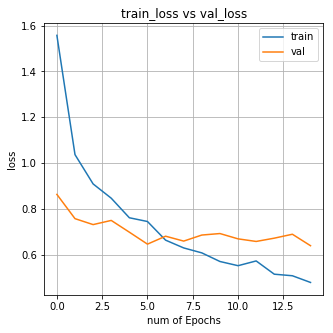

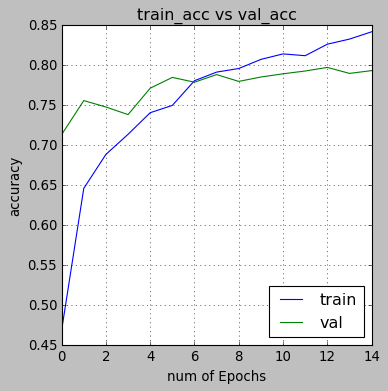

In [17]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(15)

plt.figure(1,figsize=(5,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(5,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])